In [1]:
from accelerate import Accelerator, DistributedDataParallelKwargs
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from tqdm.notebook import tqdm
from gato.policy.gato_policy import GatoPolicy
from gato.training.arguments import TrainingArgs
from gato.training.schedulers import get_linear_warmup_cosine_decay_scheduler
from gato.tasks.vqa_task import VqaTask
from gato.training.trainer import Trainer
from pathlib import Path
import wandb
%load_ext autoreload
%autoreload 2

pygame 2.5.2 (SDL 2.28.2, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


- train.py calls `trainer.train()`

# Trainer

Takes a model, optimizer, scheduler, accelerator, tasks, and other args.

`Trainer.train()` calls `train_iteration`. An iteration is `n` training steps where `n` is `args.training_steps // args.log_eval_freq`.

`train_iteration` calls `train_step` `args.log_eval_freq` number of times.

`train_step` grabs a batch from each task, calls `model.forward` on the combined list of batches, calls `backward`, then steps the optimizer and the scheduler.

After `args.log_eval_freq` number of steps, `train_iteration` will call `evaluate` on each task.

# VQA Evaluation

Why doesn't evaluate use the same logic that `train_step` uses?

`evaluate` is calling `model.predict_answer` and calculating its own loss.
`train_step` is calling `model.forward` and using the loss that `forward` returns.

In [2]:
from transformers import AutoTokenizer

In [3]:
accelerator = Accelerator(cpu=True)

In [4]:
args = TrainingArgs(
    training_steps=1,
    log_eval_freq=1,
    warmup_steps=0,
    batch_size=1,
    eval_episodes=1,
    vqa_prop=1,
    vqa_dataset='/home/eihli/src/NEKO/vqa_data',
    vqa_train_data=['train2014'],
    vqa_test_data=['val2014'],
)

In [5]:
vqa_task = VqaTask(
    args.tokenizer_model_name, 
    args.vqa_dataset, 
    args.vqa_train_data, 
    args.vqa_test_data, 
    args.train_img_name_prefix, 
    args.train_img_file_name_len, 
    args.test_img_name_prefix,
    args.test_img_file_name_len, 
    args.questions_file,
    args.annotations_file,
)

In [6]:
model = GatoPolicy(
    device=args.device,
    embed_dim=args.embed_dim,
    layers=args.layers,
    heads=args.heads,
    dropout=args.dropout,
    mu=args.mu,
    M=args.M,
    patch_size=args.patch_size,
    resid_mid_channels=args.resid_mid_channels,
    continuous_tokens=args.continuous_tokens,
    discrete_tokens=args.discrete_tokens,
    context_len=args.sequence_length,
    use_patch_pos_encoding=not args.disable_patch_pos_encoding,
    use_pos_encoding=not args.disable_inner_pos_encoding,
    activation_fn=args.activation_fn,
    pretrained_lm=args.pretrained_lm,
    flash=args.flash,
    tokenizer_model_name=args.tokenizer_model_name,
    pad_seq=args.pad_seq,
)

In [7]:
args.embed_dim = model.embed_dim

# print trainable parameters
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Trainable Parameters:', '{}M'.format(params / 1e6))
args.trainable_params = params

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=args.learning_rate,
    betas=(args.beta_1, args.beta_2),
    eps=args.adam_eps,
    weight_decay=args.weight_decay,
)
tasks = [vqa_task]

# Setup scheduler
scheduler = get_linear_warmup_cosine_decay_scheduler(optimizer, args.warmup_steps, args.training_steps, base_lr=args.learning_rate, init_lr=args.init_lr, min_lr=args.learning_rate / args.min_factor, cosine_decay=not args.disable_cosine_decay)
model, optimizer, scheduler = accelerator.prepare(model, optimizer, scheduler)

Trainable Parameters: 138.627459M


In [8]:
tokenizer_model='gpt2'
text_tokenizer = AutoTokenizer.from_pretrained(tokenizer_model)

In [9]:
datadir = Path("~/src/NEKO/vqa_data/").expanduser()

In [10]:
import json

In [11]:
with open(datadir/'mscoco_train2014_annotations.json') as f:
    annotations = json.loads(f.read())
with open(datadir/'OpenEnded_mscoco_train2014_questions.json') as f:
    questions = json.loads(f.read())

In [12]:
from typing import Union
from PIL import Image

In [13]:
def img_filepath(datadir: Path, img_id: str) -> Path:
    return Path(datadir/'train2014'/f'COCO_train2014_{img_id:>012}.jpg')

def load_img(datadir: Path, img_id: str):
    with Image.open(img_filepath(datadir, img_id)) as img:
        img = img.resize((256, 256))
        img_data = np.asarray(img)
    return img_data

import os
print(img_filepath(datadir, '71'))

img_filepath(datadir, '71').exists()

/home/eihli/src/NEKO/vqa_data/train2014/COCO_train2014_000000000071.jpg


True

In [14]:
len(questions['questions']), len(annotations['annotations'])

(9009, 9009)

In [15]:
img_id = '522741'
img_filepath(datadir, img_id).exists()

True

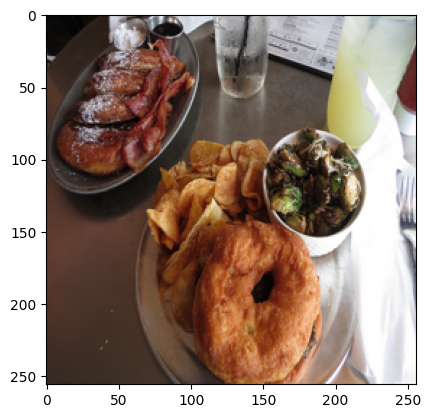

In [16]:
img = load_img(datadir, img_id)
plt.imshow(img)

In [17]:
questions['questions'][-1], annotations['annotations'][-1]

({'image_id': 522741,
  'question': 'For what meal is the food consumed?',
  'question_id': 5227415},
 {'image_id': 522741,
  'answer_type': 'other',
  'question_type': 'five',
  'question_id': 5227415,
  'answers': [{'answer_id': 1,
    'raw_answer': 'breakfast',
    'answer_confidence': 'yes',
    'answer': 'breakfast'},
   {'answer_id': 2,
    'raw_answer': 'breakfast',
    'answer_confidence': 'yes',
    'answer': 'breakfast'},
   {'answer_id': 3,
    'raw_answer': 'breakfast',
    'answer_confidence': 'yes',
    'answer': 'breakfast'},
   {'answer_id': 4,
    'raw_answer': 'breakfast',
    'answer_confidence': 'yes',
    'answer': 'breakfast'},
   {'answer_id': 5,
    'raw_answer': 'lunch',
    'answer_confidence': 'yes',
    'answer': 'lunch'},
   {'answer_id': 6,
    'raw_answer': 'lunch',
    'answer_confidence': 'yes',
    'answer': 'lunch'},
   {'answer_id': 7,
    'raw_answer': 'lunch',
    'answer_confidence': 'yes',
    'answer': 'lunch'},
   {'answer_id': 8,
    'raw_answ

These lines just extract specific parts of data from our raw data on disk.

We'll use the specific parts later on to hand-make a little example of a dataset and a batch.

In [18]:
idx = len(questions['questions']) - 1
question = questions['questions'][idx]['question']
answer = annotations['annotations'][idx]['answers'][0]['answer']
img_id = questions['questions'][idx]['image_id']
img_data = load_img(datadir, img_id)
img_data_t = img_data.transpose(2, 0, 1) # reshape from (256, 256, 3) to (3, 256, 256)
img_batched = torch.tensor(np.expand_dims(img_data_t, 0)) # Add batch dimension

img_data.shape, img_data_t.shape, img_batched.shape

((256, 256, 3), (3, 256, 256), torch.Size([1, 3, 256, 256]))

This is what the VQA dataset looks like. But in reality, it would have 80,000 or so items in the list.

https://github.com/eihli/NEKO/blob/master/gato/tasks/vqa_task.py#L88

In [19]:
mock_dataset = [
    {
        'image': img_batched,
        'question': question,
        'answers': annotations['annotations'][idx]['answers'],
    }
]

And this is an example of what gets returned by `sample_batch`. But in reality, it would have `batch_size` elements in the list.

https://github.com/eihli/NEKO/blob/master/gato/tasks/vqa_task.py#L103

In [20]:
handmade_batch = [
    {
        'image': img_batched,
        'text': text_tokenizer.encode(f'{question} {answer}')
    }
]
handmade_batch[0]['image'].shape, handmade_batch[0]['text']

(torch.Size([1, 3, 256, 256]),
 [1890, 644, 9799, 318, 262, 2057, 13529, 30, 12607])

# Evaluation before _any_ training.

Just so we have a baseline.

In [21]:
loss_fn = nn.CrossEntropyLoss()

# Use the same image/question/answer as above. I'm renaming `img_data_t` to match the variable names
# that are used in the `evaluate` method of `vqa_task.py` and I'm simply doing `question = question`
# as a reminder that these things are defined above and we aren't changing them.
image = img_batched
question = question  # See comment.
target_answer = answer

target_tokens = text_tokenizer.encode(target_answer)

# Generate prediction
#
# Note here: We're passing `question` in its _unencoded_ form to `model.predict_answer`. 
#            But in the training iteration, we're passing `question` in it's _encoded_ (tokenized) form to `model.forward`.
#            I just call this out as a curiousity/mismatched-expectation for now. I don't know if it's related to any issues.
pred_logits, pred_answer = model.predict_answer(image, question, max_length = len(target_tokens),deterministic=True)
loss = loss_fn(pred_logits, torch.tensor(target_tokens).to(model.device))

print(f'Question: {question}')
print(f'Target answer: {target_answer} \n Predicted answer : {pred_answer}')
print(f'Loss: {loss}')
print("----")

Question: For what meal is the food consumed?
Target answer: breakfast 
 Predicted answer : zbekconserv
Loss: 11.691234588623047
----


# Training iteration

Let's do a forward pass, calculate the loss, a backward pass, calculate the loss again, and see the loss decrease.

Because we only have a single data sample in our batch, we're definitely overfitting. But we at least have a simple toy example we can play with. If everything works as expected, we'll continue to expand on our toy example. If we run into something that doesn't work as we expect, then the simplicity of the example will make it easier to identify the issue.

In [22]:
logits, loss = model.forward(inputs=handmade_batch, compute_loss=True)

In [23]:
loss

tensor(10.7218, grad_fn=<NllLossBackward0>)

In [24]:
accelerator.backward(loss)

In [25]:
optimizer.step()
scheduler.step()
optimizer.zero_grad()

In [26]:
logits, loss = model.forward(inputs=handmade_batch, compute_loss=True)
loss

tensor(10.9410, grad_fn=<NllLossBackward0>)

Let's let it run for a bit.

In [27]:
losses = []
for _ in tqdm(range(10)):
    logits, loss = model.forward(inputs=handmade_batch, compute_loss=True)
    losses.append(loss.item())
    accelerator.backward(loss)
    
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
losses

  0%|          | 0/10 [00:00<?, ?it/s]

[10.829832077026367,
 10.357330322265625,
 6.839217662811279,
 6.443039417266846,
 3.785407066345215,
 3.647425889968872,
 1.87190580368042,
 1.7374333143234253,
 0.8093905448913574,
 0.7713815569877625]

There doesn't seem to be anything out of the ordinary with the training loop. (Assuming we copied with high fidelity the training loop from the codebase.) Let's check evaluation.

# Evaluation

https://github.com/eihli/NEKO/blob/master/gato/tasks/vqa_task.py#L105

Looking at the evaluation code and comparing it to the training code, I wonder if there's differences in how the data is batched, transformed, tokenized, etc... that might be causing the discrepency.

The evaluation images come from `dataset['test']` (vs. `dataset['train']` for the training runs). They are both processed the same — through `process_data`. They are both a list of dictionaries where each dictionary is an image/question/answers.

One thing that I notice is that we're calculating loss a little bit differently between the training loop and the evaluation loop.

`loss` in the training loop comes from:

`logits, loss = self.model.forward(inputs = combined_batch_dicts, compute_loss=True)`

https://github.com/eihli/NEKO/blob/master/gato/training/trainer.py#L177

`loss` in the evaluation loop comes from:

`loss_fn = nn.CrossEntropyLoss()`

https://github.com/eihli/NEKO/blob/master/gato/tasks/vqa_task.py#L107

In [28]:
text_tokenizer.eos_token, text_tokenizer.bos_token

('<|endoftext|>', '<|endoftext|>')

In [29]:
loss_fn = nn.CrossEntropyLoss()

# Use the same image/question/answer as above. I'm renaming `img_data_t` to match the variable names
# that are used in the `evaluate` method of `vqa_task.py` and I'm simply doing `question = question`
# as a reminder that these things are defined above and we aren't changing them.
image = img_batched
question = question  # See comment.
target_answer = answer

target_tokens = text_tokenizer.encode(target_answer)

# Generate prediction
#
# Note here: We're passing `question` in its _unencoded_ form to `model.predict_answer`. 
#            But in the training iteration, we're passing `question` in it's _encoded_ (tokenized) form to `model.forward`.
#            I just call this out as a curiousity/mismatched-expectation for now. I don't know if it's related to any issues.
pred_logits, pred_answer = model.predict_answer(image, question, max_length=len(target_tokens), deterministic=True)
loss = loss_fn(pred_logits, torch.tensor(target_tokens).to(model.device))

print(f'Question: {question}')
print(f'Target answer: {target_answer} \n Predicted answer : {pred_answer}')
print(f'Loss: {loss}')
print("----")

Question: For what meal is the food consumed?
Target answer: breakfast 
 Predicted answer : zbek pauses
Loss: 11.552677154541016
----


In [30]:
loss_fn = nn.CrossEntropyLoss()

# Use the same image/question/answer as above. I'm renaming `img_data_t` to match the variable names
# that are used in the `evaluate` method of `vqa_task.py` and I'm simply doing `question = question`
# as a reminder that these things are defined above and we aren't changing them.
image = img_batched
question = question  # See comment.
target_answer = answer

target_tokens = text_tokenizer.encode(target_answer)

# Generate prediction
#
# Note here: We're passing `question` in its _unencoded_ form to `model.predict_answer`. 
#            But in the training iteration, we're passing `question` in it's _encoded_ (tokenized) form to `model.forward`.
#            I just call this out as a curiousity/mismatched-expectation for now. I don't know if it's related to any issues.
pred_logits, pred_answer = model.predict_answer(image, question, max_length = len(target_tokens),deterministic=True)
loss = loss_fn(pred_logits, torch.tensor(target_tokens).to(model.device))

print(f'Question: {question}')
print(f'Target answer: {target_answer} \n Predicted answer : {pred_answer}')
print(f'Loss: {loss}')
print("----")

Question: For what meal is the food consumed?
Target answer: breakfast 
 Predicted answer : zbekconserv
Loss: 11.435468673706055
----
